# Setup

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
from six.moves import range, zip, map, reduce, filter

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.colors as mpl_colors
from scipy.stats import entropy
from sklearn.metrics import confusion_matrix
import itertools
import warnings
from IPython import display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import seaborn as sns
sns.set_style('whitegrid')
plt.rc('figure', figsize=(7.0, 5.0))

In [36]:
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Activation, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import LambdaCallback
from keras.utils import np_utils
from keras_tqdm import TQDMNotebookCallback

In [5]:
def plot_callback(func,p=20):
    def plot_epoch_end(epoch,logs):
        if epoch == 0 or (epoch+1) % p == 0:
            plt.clf(); func(); # plt.title('epoch %d' % (epoch+1))
            display.clear_output(wait=True); display.display(plt.gcf())
    def clear(*args):
        plt.clf()
    return LambdaCallback(on_epoch_end=plot_epoch_end,on_train_end=clear)

In [6]:
def plot_loss_acc(hist):
    plt.figure(figsize=(15,4));
    plt.subplot(121); plt.semilogy(hist.epoch,hist.history['loss'], hist.epoch,hist.history['val_loss']);
    plt.xlabel('epoch'); plt.ylabel('loss'); plt.legend(['train','test'],loc='upper right')
    plt.subplot(122); plt.plot(hist.epoch,hist.history['acc'], hist.epoch,hist.history['val_acc'])
    plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.legend(['train','test'],loc='lower right');        

In [7]:
classes = 10
def pred_hist(p):
    plt.bar(range(classes),p,align='center',width=0.8)
    plt.grid('off');
    plt.xlim(0-0.4,classes-1+0.4); plt.xticks(range(classes),position=(0.5,0.05),fontsize=8)
    plt.ylim(0,1); plt.yticks(())
def pred_hist_h(p):
    plt.barh(range(classes),p,align='center',height=0.8)
    plt.grid('off');
    plt.xlim(0,1); plt.xticks(())
    plt.ylim(0-0.4,classes-1+0.4); plt.yticks(range(classes),position=(0.05,0.5),fontsize=8)

In [8]:
def plot_confusion_matrix(cm):
    # adapted from http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.figure(figsize=(8,6))
        color_norm = mpl_colors.LogNorm(vmin=max(1,cm.min()), vmax=cm.max())
        plt.imshow(cm,interpolation="nearest", cmap=plt.cm.Blues, norm=color_norm)
        plt.grid('off'); tick_marks = np.arange(classes); plt.xticks(tick_marks); plt.yticks(tick_marks)
        thresh = cm.max()/2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j,i,cm[i,j],horizontalalignment="center",
                     color="white" if cm[i,j] > thresh else "black")
        plt.tight_layout(); plt.colorbar()
        plt.ylabel('true class'); plt.xlabel('predicted class')

---

Adapted from https://github.com/wxs/keras-mnist-tutorial/blob/master/MNIST%20in%20Keras.ipynb

---

# Data

In [9]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

print('image size          = %dx%d' % (X_train.shape[1], X_train.shape[2]))
print('no. of train images = %d'    % X_train.shape[0])
print('no. of test  images = %d'    % X_test.shape[0])

image size          = 28x28
no. of train images = 60000
no. of test  images = 10000


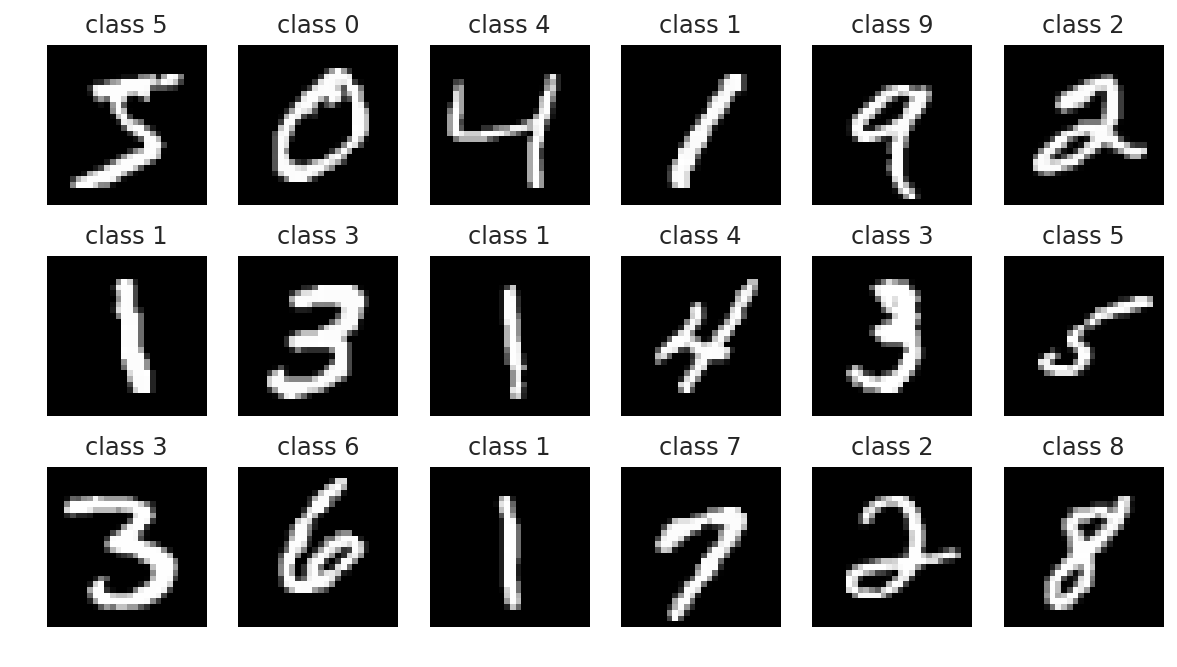

In [10]:
plt.figure(figsize=(10,5.5))
for i in range(18):
    plt.subplot(3,6,i+1)
    plt.imshow(X_train[i], cmap='gray', interpolation='nearest')
    plt.axis('off'); plt.title('class %d' % y_train[i])
None;

## Preprocessing

In [11]:
X_train = X_train.astype(np.float32) / 255
X_test  = X_test.astype(np.float32) / 255
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [12]:
Y_train = np_utils.to_categorical(y_train, classes)
Y_test = np_utils.to_categorical(y_test, classes)
Y_train.shape, Y_test.shape

((60000, 10), (10000, 10))

In [13]:
def show_examples(ind_show,yhat_test,yhat_test_classes):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        plt.figure(figsize=(10,5.5))
        for i, k in enumerate(ind_show[:9]):
            plt.subplot(3,6,2*i+1)
            plt.imshow(X_test[k].reshape(28,28), cmap='gray', interpolation='nearest')
            col = 'g' if y_test[k] == yhat_test_classes[k] else 'r'
            plt.gca().add_patch(patches.Rectangle((0,0),27,27,linewidth=2,edgecolor=col,facecolor='none'))
            plt.axis('off'); plt.title('class %d, predicted %d' % (y_test[k], yhat_test_classes[k]),fontsize=10)
            plt.subplot(3,6,2*i+2)
            pred_hist(yhat_test[k])

# Model 1

Image from https://github.com/wxs/keras-mnist-tutorial
![](https://raw.githubusercontent.com/wxs/keras-mnist-tutorial/8824b7b56963a92ef879f09acd99cf3a210db2b8/figure.png)

In [14]:
def get_model():
    inp = Input(     name='X', shape=X_train.shape[1:])
    t   = Flatten(   name='X_vector')(inp)
    t   = Dense(512, name='L1', activation='relu')(t)
    t   = Dense(512, name='L2', activation='relu')(t)
    oup = Dense(10,  name='Y', activation='softmax')(t)
    model = Model(inp,oup)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

In [15]:
model = get_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 28, 28)            0         
_________________________________________________________________
X_vector (Flatten)           (None, 784)               0         
_________________________________________________________________
L1 (Dense)                   (None, 512)               401920    
_________________________________________________________________
L2 (Dense)                   (None, 512)               262656    
_________________________________________________________________
Y (Dense)                    (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


# Train

In [16]:
hist = model.fit(X_train,Y_train, validation_data=(X_test,Y_test), batch_size=128, epochs=15)

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 3s 58us/step - loss: 0.2208 - acc: 0.9347 - val_loss: 0.1158 - val_acc: 0.9643
Epoch 2/15
60000/60000 [==============================] - 2s 39us/step - loss: 0.0789 - acc: 0.9751 - val_loss: 0.0801 - val_acc: 0.9749
Epoch 3/15
60000/60000 [==============================] - 2s 39us/step - loss: 0.0500 - acc: 0.9840 - val_loss: 0.0737 - val_acc: 0.9762
Epoch 4/15
60000/60000 [==============================] - 2s 39us/step - loss: 0.0354 - acc: 0.9882 - val_loss: 0.0638 - val_acc: 0.9798
Epoch 5/15
60000/60000 [==============================] - 2s 39us/step - loss: 0.0276 - acc: 0.9915 - val_loss: 0.0676 - val_acc: 0.9809
Epoch 6/15
60000/60000 [==============================] - 2s 39us/step - loss: 0.0220 - acc: 0.9928 - val_loss: 0.0757 - val_acc: 0.9798
Epoch 7/15
60000/60000 [==============================] - 2s 39us/step - loss: 0.0205 - acc: 0.9930 - val_loss: 0.0742 - val_acc

# Evaluate

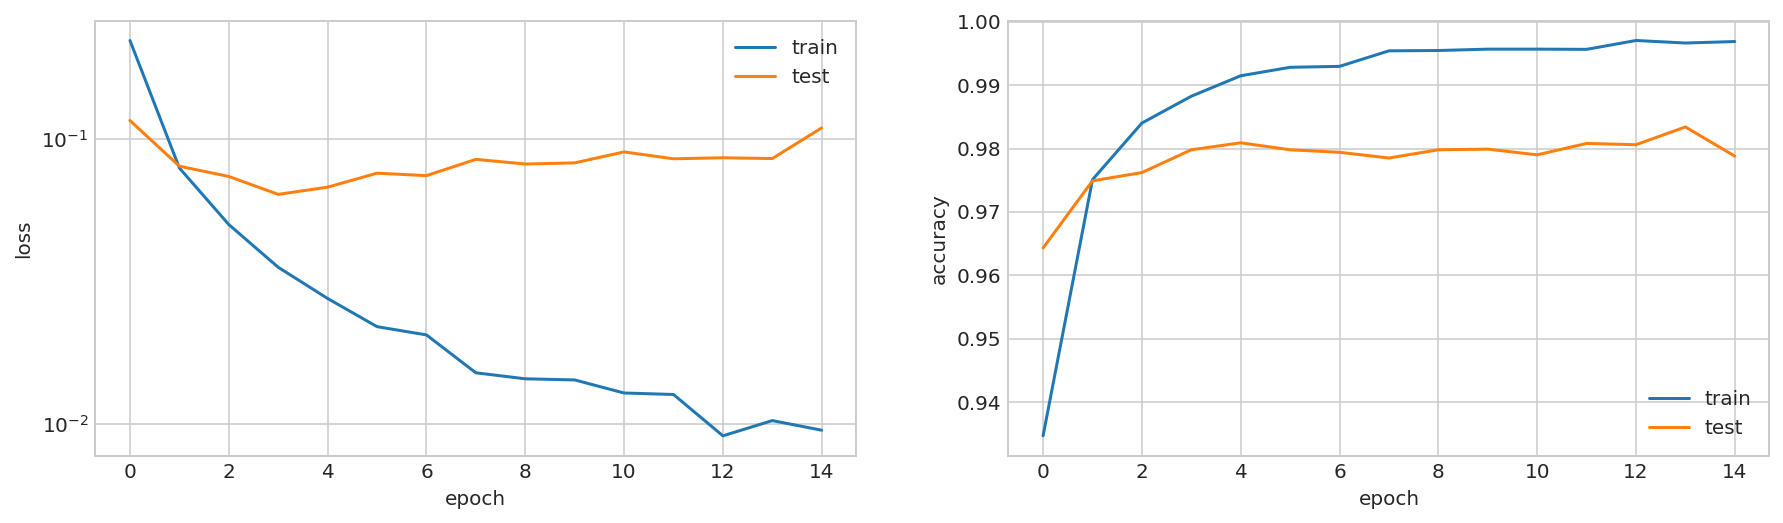

In [17]:
plot_loss_acc(hist)

In [18]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:     ', loss)
print('Test accuracy: ', accuracy)

Test loss:      0.10911156847946021
Test accuracy:  0.9788


In [19]:
yhat_test         = model.predict(X_test,verbose=0)
yhat_test_classes = np.argmax(yhat_test,axis=1)

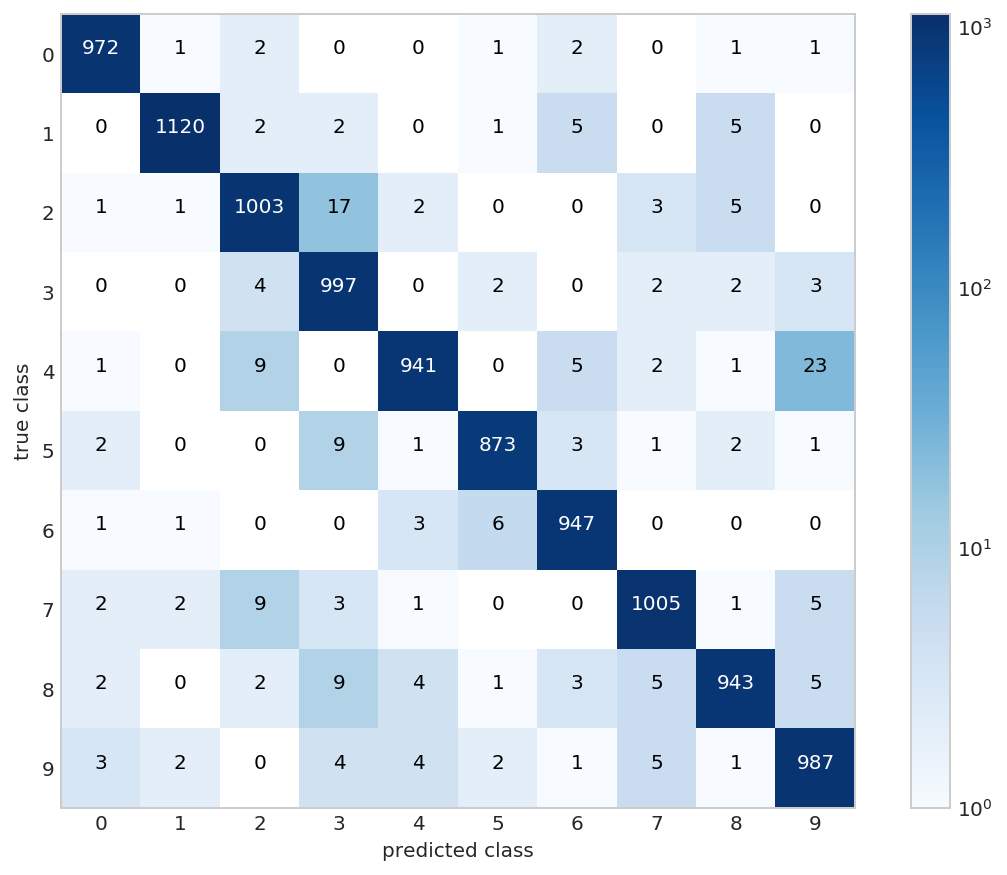

In [20]:
plot_confusion_matrix(confusion_matrix(y_test, yhat_test_classes))

## Examples

In [21]:
yhat_test_entropies = entropy(yhat_test.T)
ind_correct = np.nonzero(yhat_test_classes == y_test)[0]
ind_wrong   = np.nonzero(yhat_test_classes != y_test)[0]
ind_uncertainty_sorted = np.argsort(yhat_test_entropies)
len(ind_correct), len(ind_wrong)

(9788, 212)

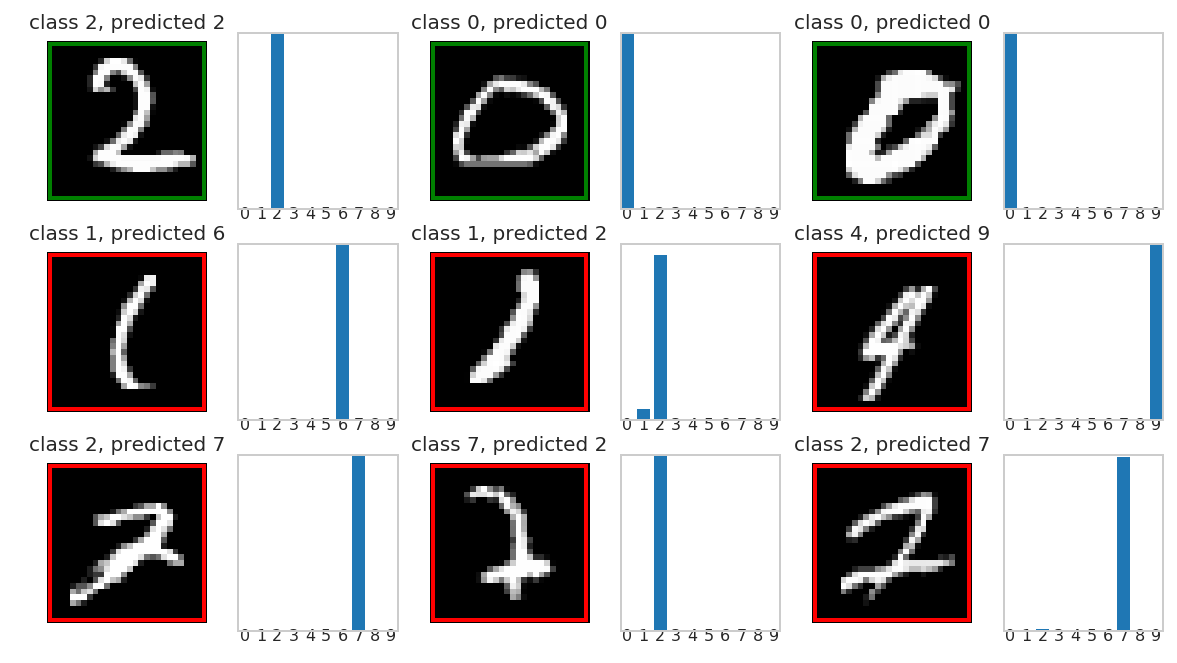

In [22]:
ind_show = np.concatenate((np.random.choice(ind_correct, 3, replace=False),
                           np.random.choice(ind_wrong,   6, replace=False)))
show_examples(ind_show,yhat_test,yhat_test_classes)

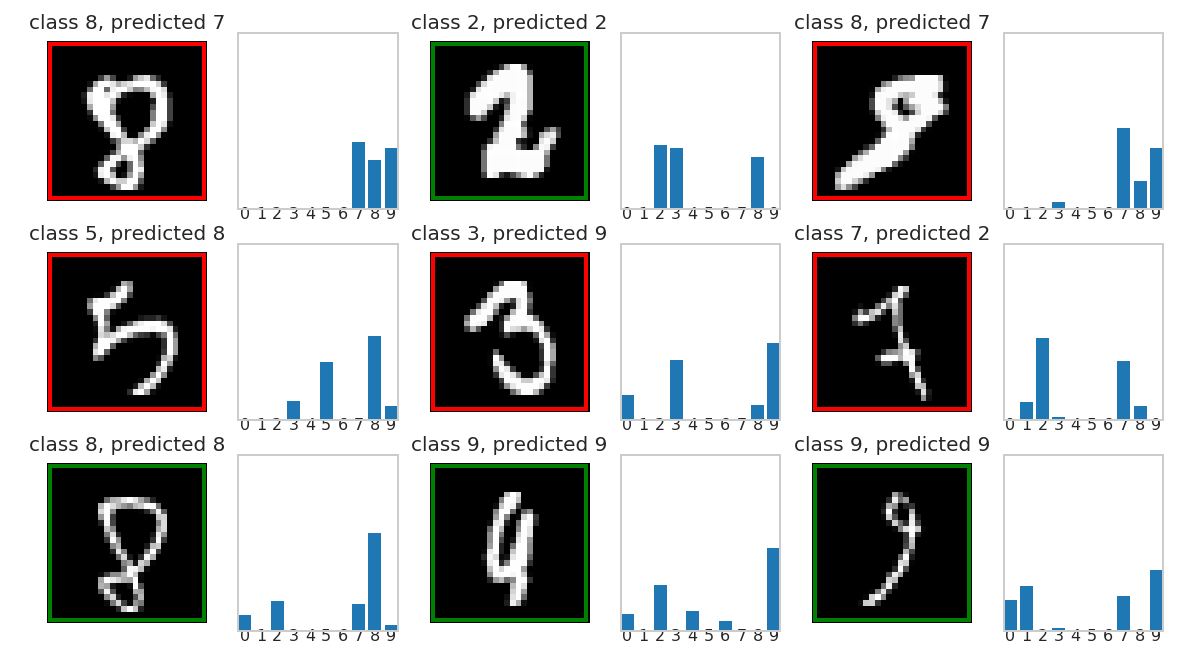

In [23]:
ind_show = ind_uncertainty_sorted[-9:]
show_examples(ind_show,yhat_test,yhat_test_classes)

## Training with Visualization

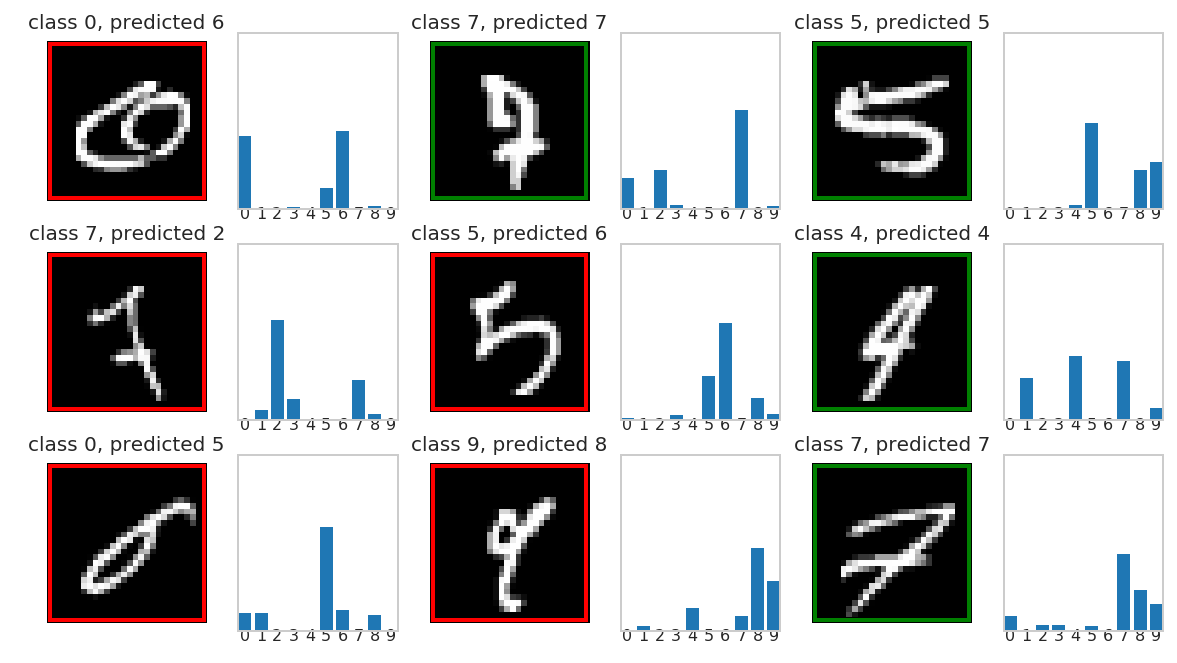

<Figure size 504x360 with 0 Axes>

<Figure size 720x396 with 0 Axes>

<Figure size 720x396 with 0 Axes>

<Figure size 720x396 with 0 Axes>

<Figure size 720x396 with 0 Axes>

<Figure size 720x396 with 0 Axes>

<Figure size 720x396 with 0 Axes>

<Figure size 720x396 with 0 Axes>

<Figure size 720x396 with 0 Axes>

<Figure size 720x396 with 0 Axes>

<Figure size 720x396 with 0 Axes>

In [24]:
model = get_model()

def uncertain_examples():
    yhat_test         = model.predict(X_test,verbose=0)
    yhat_test_classes = np.argmax(yhat_test,axis=1)
    yhat_test_entropies = entropy(yhat_test.T)
    ind_uncertainty_sorted = np.argsort(yhat_test_entropies)
    ind_show = ind_uncertainty_sorted[-9:]
    show_examples(ind_show,yhat_test,yhat_test_classes)
    
model.fit(X_train,Y_train, batch_size=128, epochs=10, verbose=0,
          callbacks=[plot_callback(uncertain_examples,1),TQDMNotebookCallback()])

# Model 2 (CNN)

In [25]:
# data size for conv layer
X_train = np.expand_dims(X_train,-1)
X_test  = np.expand_dims(X_test,-1)

In [26]:
def get_model2():
    inp = Input(       name='X',     shape=X_train.shape[1:])    
    t   = Conv2D(32,   name='conv1', kernel_size=(3,3), activation='relu')(inp)
    t   = Conv2D(32,   name='conv2', kernel_size=(3,3), activation='relu')(t)
    t   = MaxPooling2D(name='pool1', pool_size=(2,2))(t)
    t   = Conv2D(32,   name='conv3', kernel_size=(3,3), activation='relu')(t)
    t   = Conv2D(32,   name='conv4', kernel_size=(3,3), activation='relu')(t)
    t   = MaxPooling2D(name='pool2', pool_size=(2,2))(t)
    t   = Flatten(     name='flat')(t)
    #t   = Dense(64,   name='dense', activation='relu')(t)
    oup = Dense(10,    name='Y', activation='softmax')(t)
    model = Model(inp,oup)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
    return model

In [27]:
model = get_model2()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
X (InputLayer)               (None, 28, 28, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 26, 26, 32)        320       
_________________________________________________________________
conv2 (Conv2D)               (None, 24, 24, 32)        9248      
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 12, 12, 32)        0         
_________________________________________________________________
conv3 (Conv2D)               (None, 10, 10, 32)        9248      
_________________________________________________________________
conv4 (Conv2D)               (None, 8, 8, 32)          9248      
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 4, 4, 32)          0         
__________

In [28]:
hist = model.fit(X_train,Y_train, validation_data=(X_test,Y_test), batch_size=128, epochs=15)

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 6s 94us/step - loss: 0.2548 - acc: 0.9236 - val_loss: 0.0789 - val_acc: 0.9754
Epoch 2/15
60000/60000 [==============================] - 5s 79us/step - loss: 0.0638 - acc: 0.9807 - val_loss: 0.0438 - val_acc: 0.9870
Epoch 3/15
60000/60000 [==============================] - 5s 77us/step - loss: 0.0461 - acc: 0.9851 - val_loss: 0.0330 - val_acc: 0.9880
Epoch 4/15
60000/60000 [==============================] - 5s 79us/step - loss: 0.0350 - acc: 0.9889 - val_loss: 0.0392 - val_acc: 0.9874
Epoch 5/15
60000/60000 [==============================] - 5s 79us/step - loss: 0.0290 - acc: 0.9908 - val_loss: 0.0350 - val_acc: 0.9885
Epoch 6/15
60000/60000 [==============================] - 5s 78us/step - loss: 0.0239 - acc: 0.9925 - val_loss: 0.0274 - val_acc: 0.9915
Epoch 7/15
60000/60000 [==============================] - 5s 77us/step - loss: 0.0207 - acc: 0.9935 - val_loss: 0.0334 - val_acc

# Evaluate

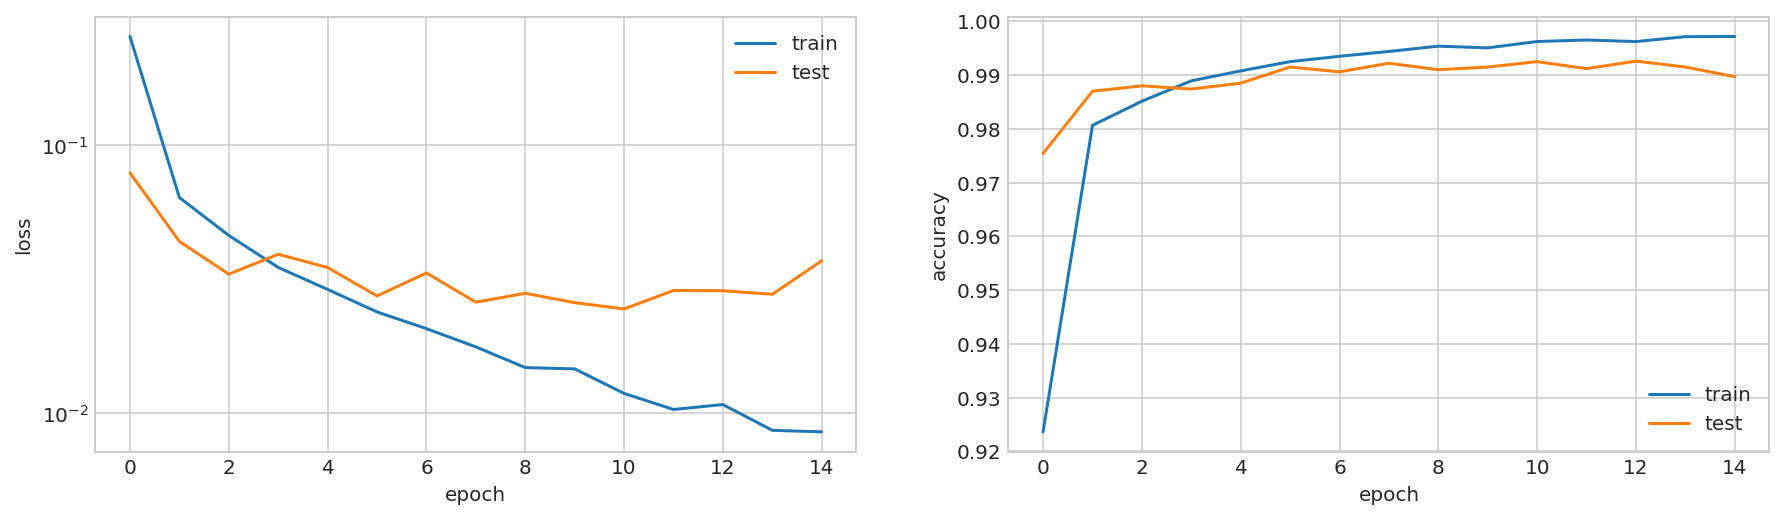

In [29]:
plot_loss_acc(hist)

In [30]:
loss, accuracy = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:     ', loss)
print('Test accuracy: ', accuracy)

Test loss:      0.037066855424644746
Test accuracy:  0.9897


In [31]:
yhat_test         = model.predict(X_test,verbose=0)
yhat_test_classes = np.argmax(yhat_test,axis=1)

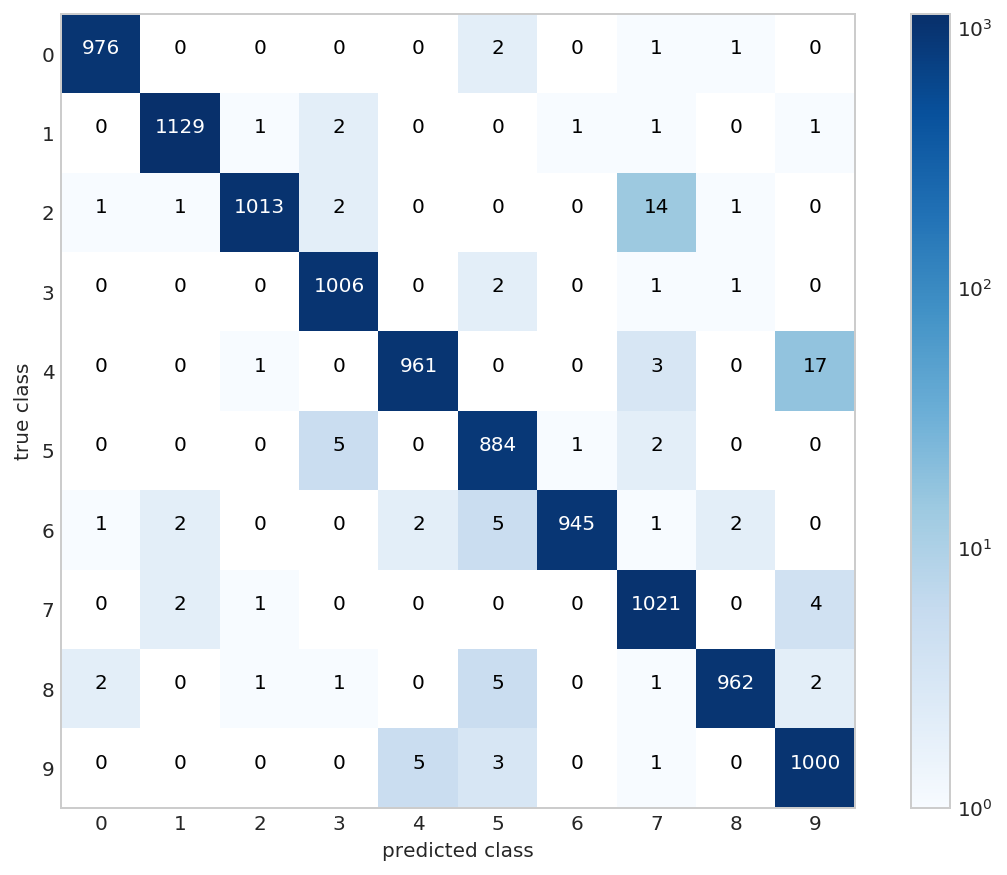

In [32]:
plot_confusion_matrix(confusion_matrix(y_test, yhat_test_classes))

## Examples

In [33]:
yhat_test_entropies = entropy(yhat_test.T)
ind_correct = np.nonzero(yhat_test_classes == y_test)[0]
ind_wrong   = np.nonzero(yhat_test_classes != y_test)[0]
ind_uncertainty_sorted = np.argsort(yhat_test_entropies)
len(ind_correct), len(ind_wrong)

(9897, 103)

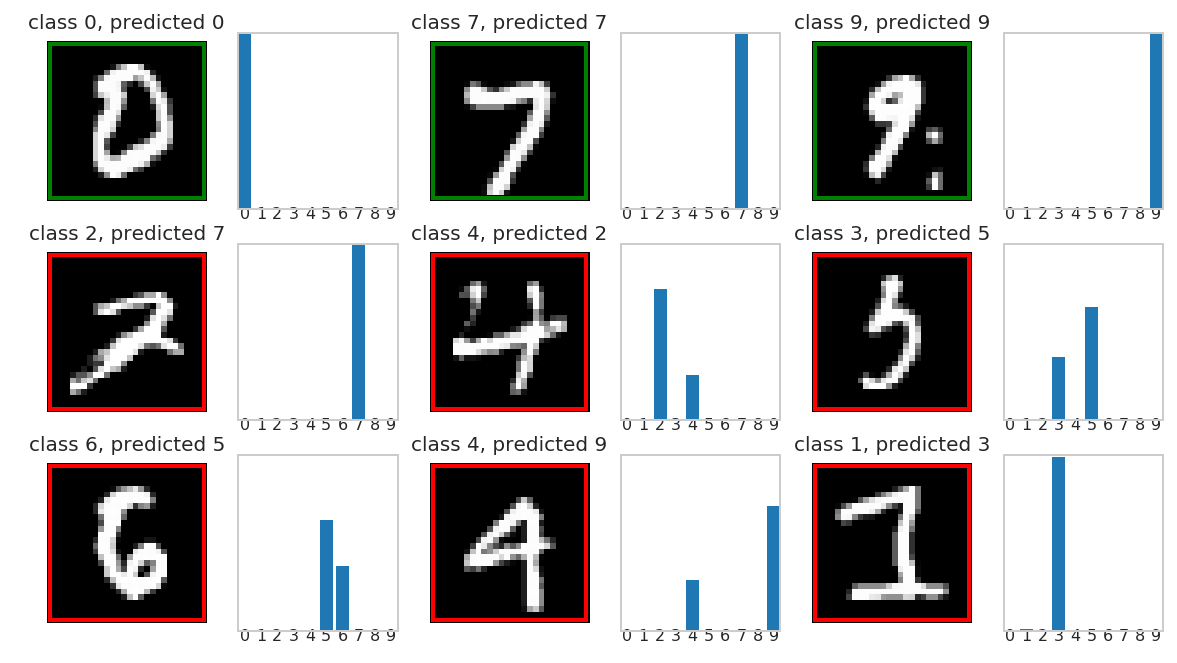

In [34]:
ind_show = np.concatenate((np.random.choice(ind_correct, 3, replace=False),
                           np.random.choice(ind_wrong,   6, replace=False)))
show_examples(ind_show,yhat_test,yhat_test_classes)

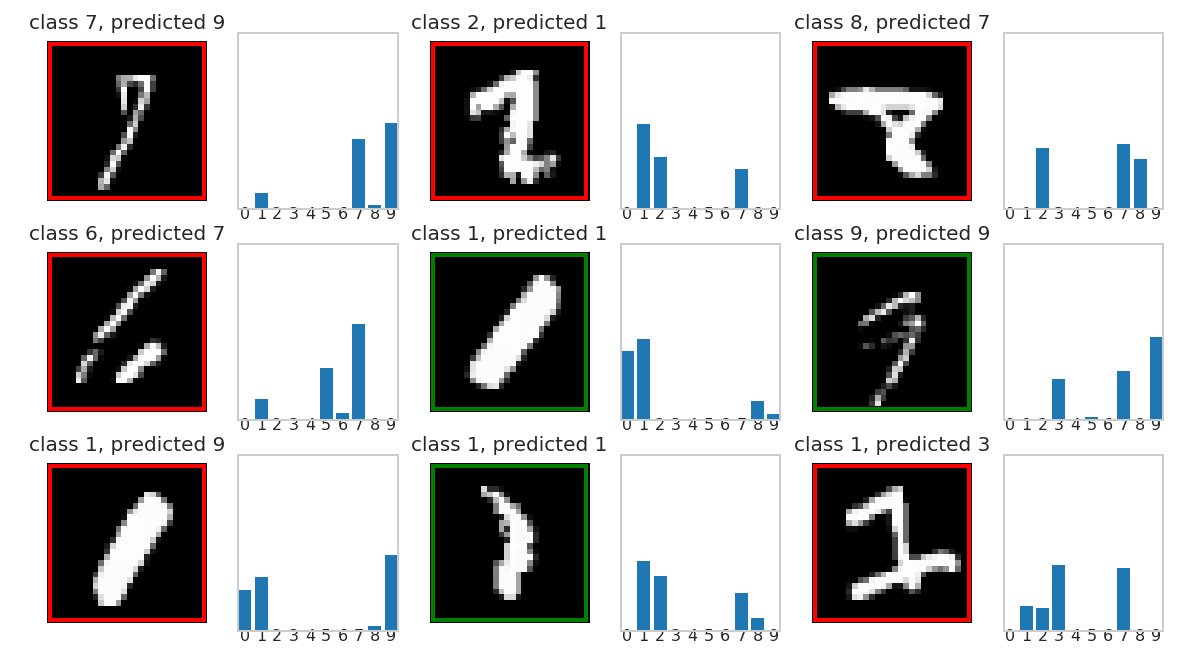

In [35]:
ind_show = ind_uncertainty_sorted[-9:]
show_examples(ind_show,yhat_test,yhat_test_classes)